In [69]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Rather than try to ID all lines, instead fit all lines in Linsky paper, and get upper limits for Peacock+ lines.

In [2]:
line_tab = Table.read('linsky_lines.tsv', format ='ascii')
line_tab

Wavelength,Ion,Formation,α Cen A (G2 V),ϵ Eri (K2 V),AU Mic (dM1e),mult,t_uncert
float64,str8,float64,float64,float64,float64,str4,str4
30.392,Heii,4.9,4.7,33.0,340.0,--,TRUE
58.4334,Hei,4.65,--,--,--,--,TRUE
97.702,Ciii,4.72,5.2,13.5,79.6,--,--
102.572,Hi (Lyβ),4.5,--,--,--,--,TRUE
103.193,Ovi,5.43,2.21,14.5,109.0,--,--
103.634,Cii,4.3,0.188,0.502,3.64,--,--
103.702,Cii,4.3,0.283,1.04,6.76,--,--
103.762,Ovi,5.43,1.06,7.67,55.1,--,--
117.6,Ciii,4.72,2.48,10.9,66.0,TRUE,--


In [3]:
lines = line_tab['Wavelength']*10
len(lines[lines > 1100])

29

In [4]:
#t1data = Table.read('../combined/trappist-1_sed_var_res_v04.ecsv')
t1data = Table.read('../../common/quicksaves/2MASS-J23062928-0502285_basic.ecsv')

In [5]:
w, f , e = t1data['WAVELENGTH'], t1data['FLUX'], t1data['ERROR']

In [6]:
cos_cut = (w > 1100) & (w < 3100)
w, f, e = w[cos_cut], f[cos_cut], e[cos_cut]

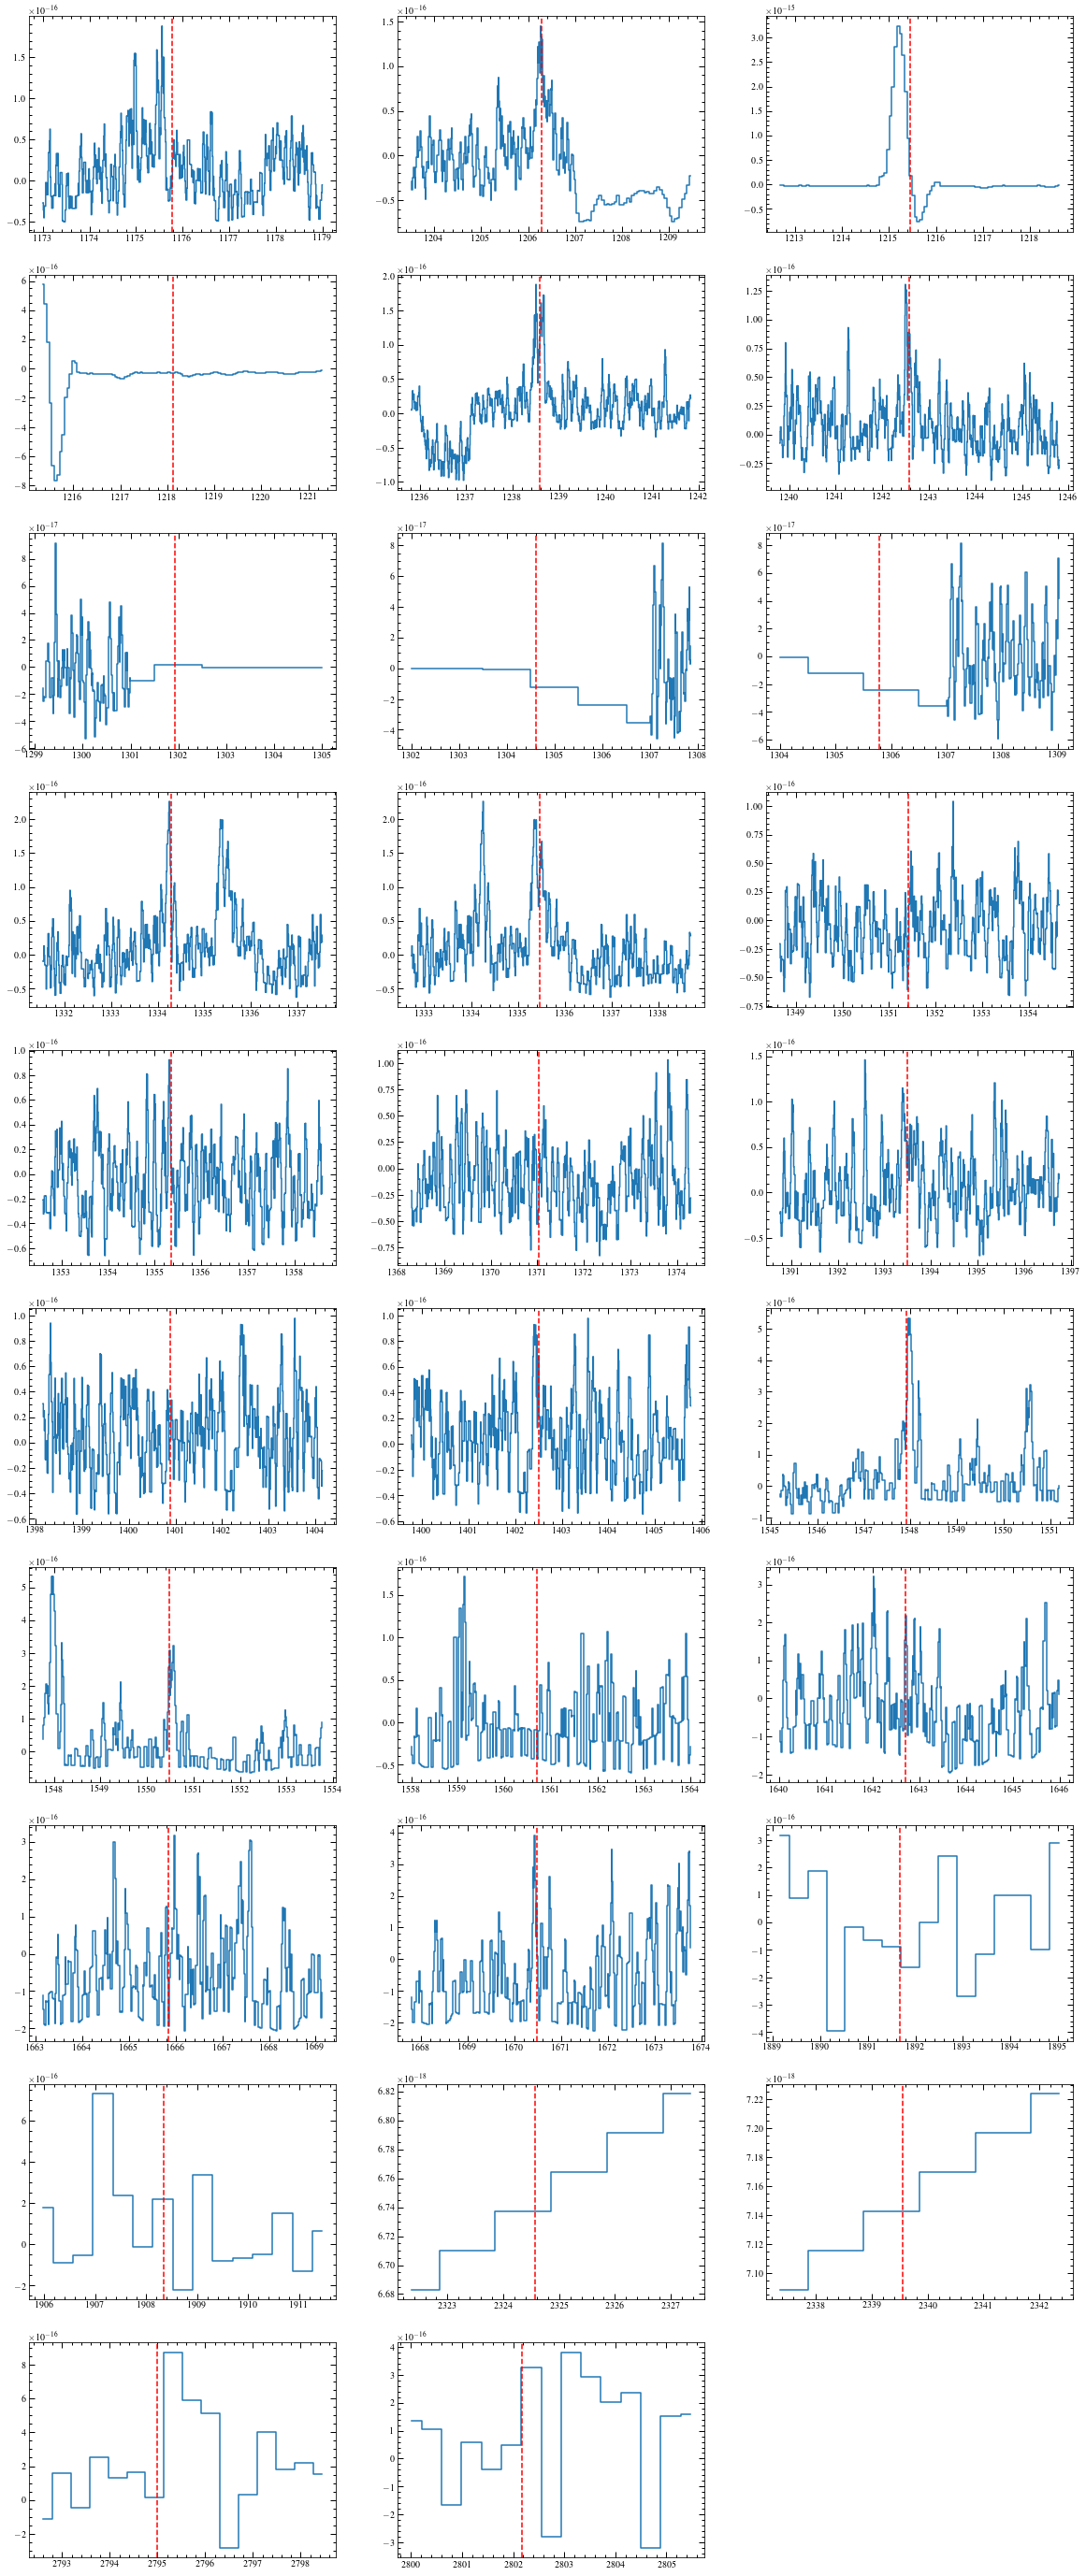

In [7]:
smooth = 5
dv = -56.3*u.km/u.s
plt.figure(figsize=(20, 50))
for i, line in enumerate(lines[lines > 1100]):
    line_mask = (w > line-3) & (w < line+3)
    w1, f1, e1 = w[line_mask], f[line_mask], e[line_mask]
    if line < 1750:
        f1 = convolve(f1,Box1DKernel(smooth))
        e1 = convolve(e1,Box1DKernel(smooth))/smooth**0.5
    #plt.figure(figsize=(5,5))
    plt.subplot(10, 3, i+1)
    plt.step(w1, f1, where='mid')
    dv_line = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA))
    plt.axvline(dv_line.value, c='r', ls='--')
    #plt.show()

In [8]:
line_data = [1176., 1206.51, 1218.344, 1238.821, 1242.804,
       1334.532, 1335.708, 1351.657,
       1355.598, 1371.292, 1393.755, 1401.156, 1402.77 , 1548.195,
       1550.77 , 1561.   , 1643.   , 1666.153, 1670.787, 2795.523, 2802.697] #lines for which data exists

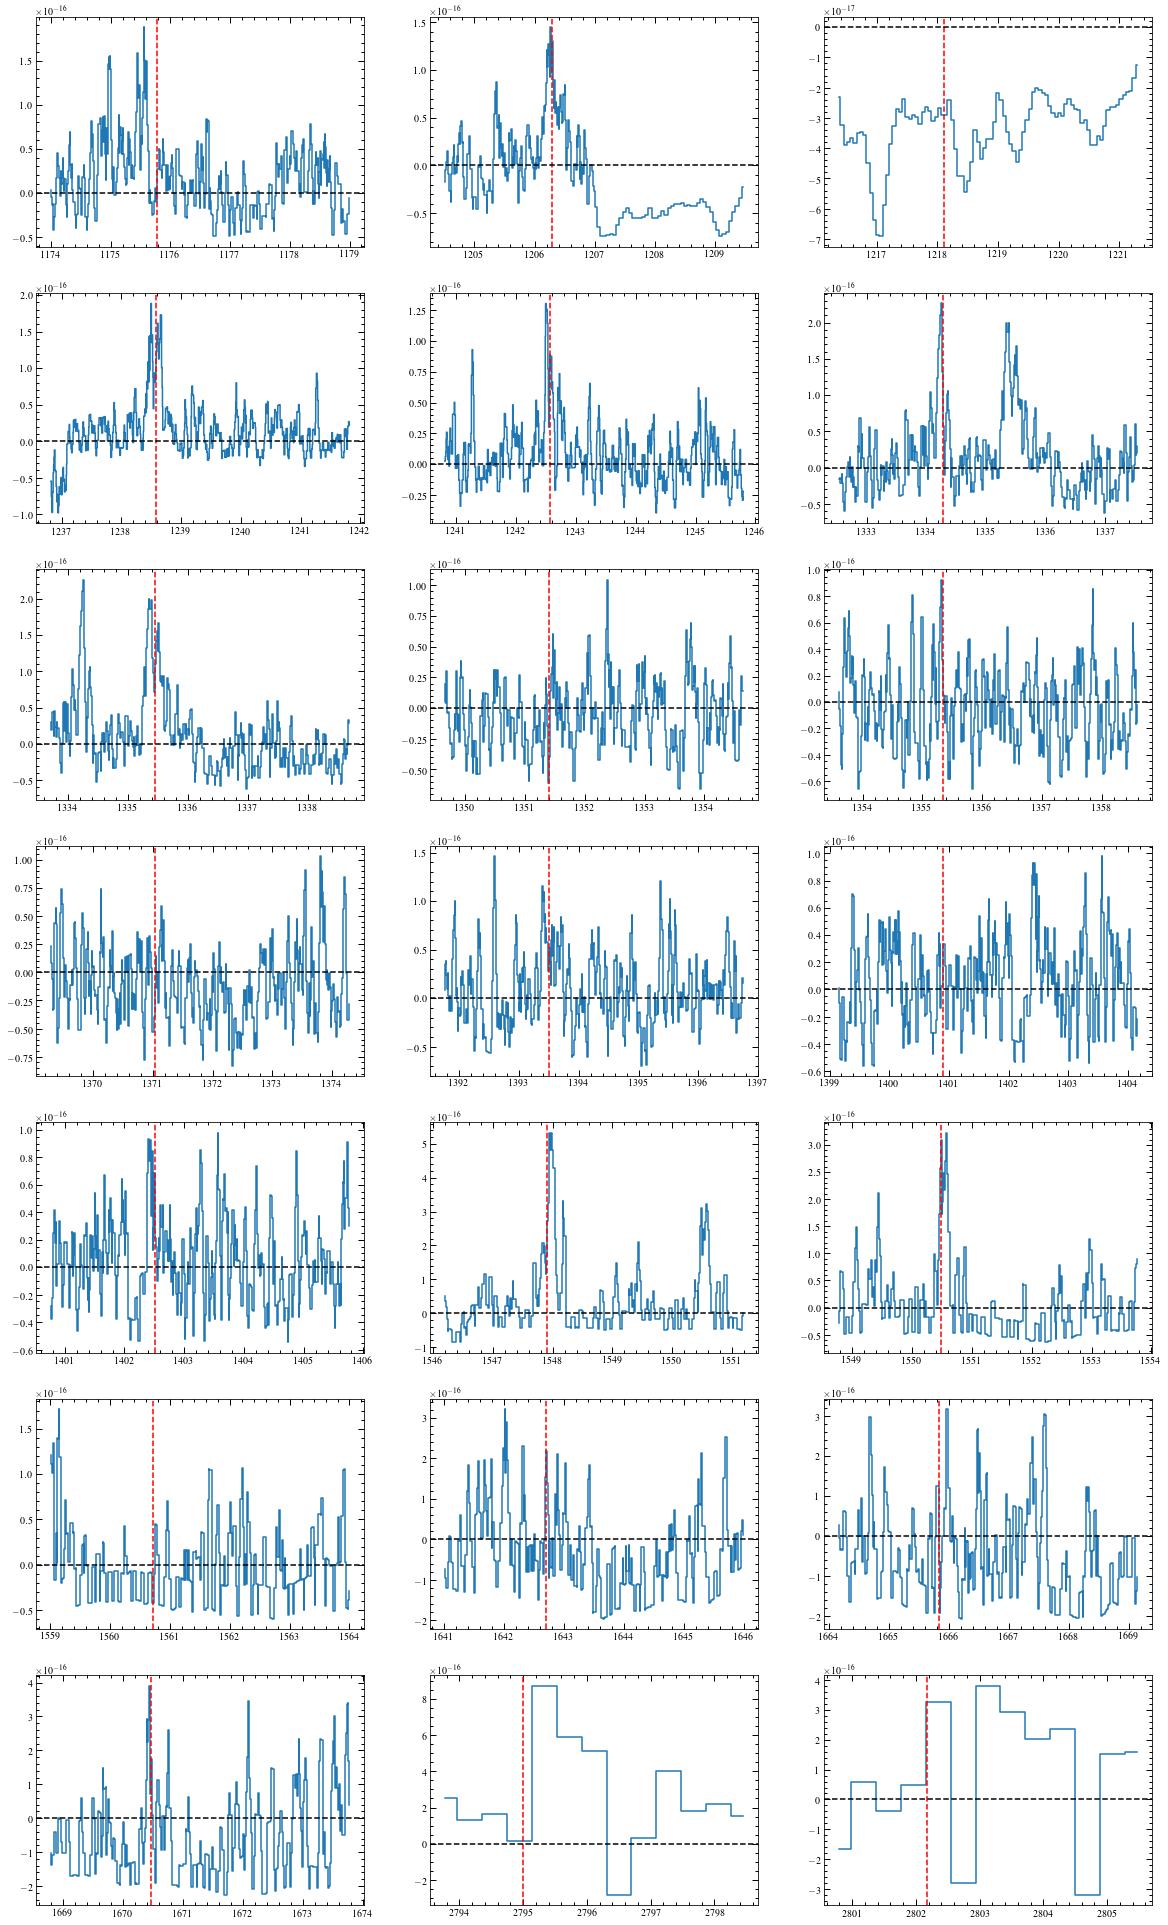

In [9]:
plt.figure(figsize=(20, 50))
for i, line in enumerate(line_data):
    line_mask = (w > line-2) & (w < line+3)
    w1, f1, e1 = w[line_mask], f[line_mask], e[line_mask]
    if line < 1750:
        f1 = convolve(f1,Box1DKernel(smooth))
        e1 = convolve(e1,Box1DKernel(smooth))/smooth**0.5
    #plt.figure(figsize=(5,5))
    plt.subplot(10, 3, i+1)
    plt.step(w1, f1, where='mid')
    dv_line = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA))
    plt.axvline(dv_line.value, c='r', ls='--')
    plt.axhline(0,c='k', ls='--')

In [10]:
detected_lines = [1176., 1206.51, 1238.821, 1242.804,
       1334.532, 1335.708, 1393.755, 1402.77 , 1548.195,
       1550.77, 1670.787, 2795.523] #lines that are  visually detected

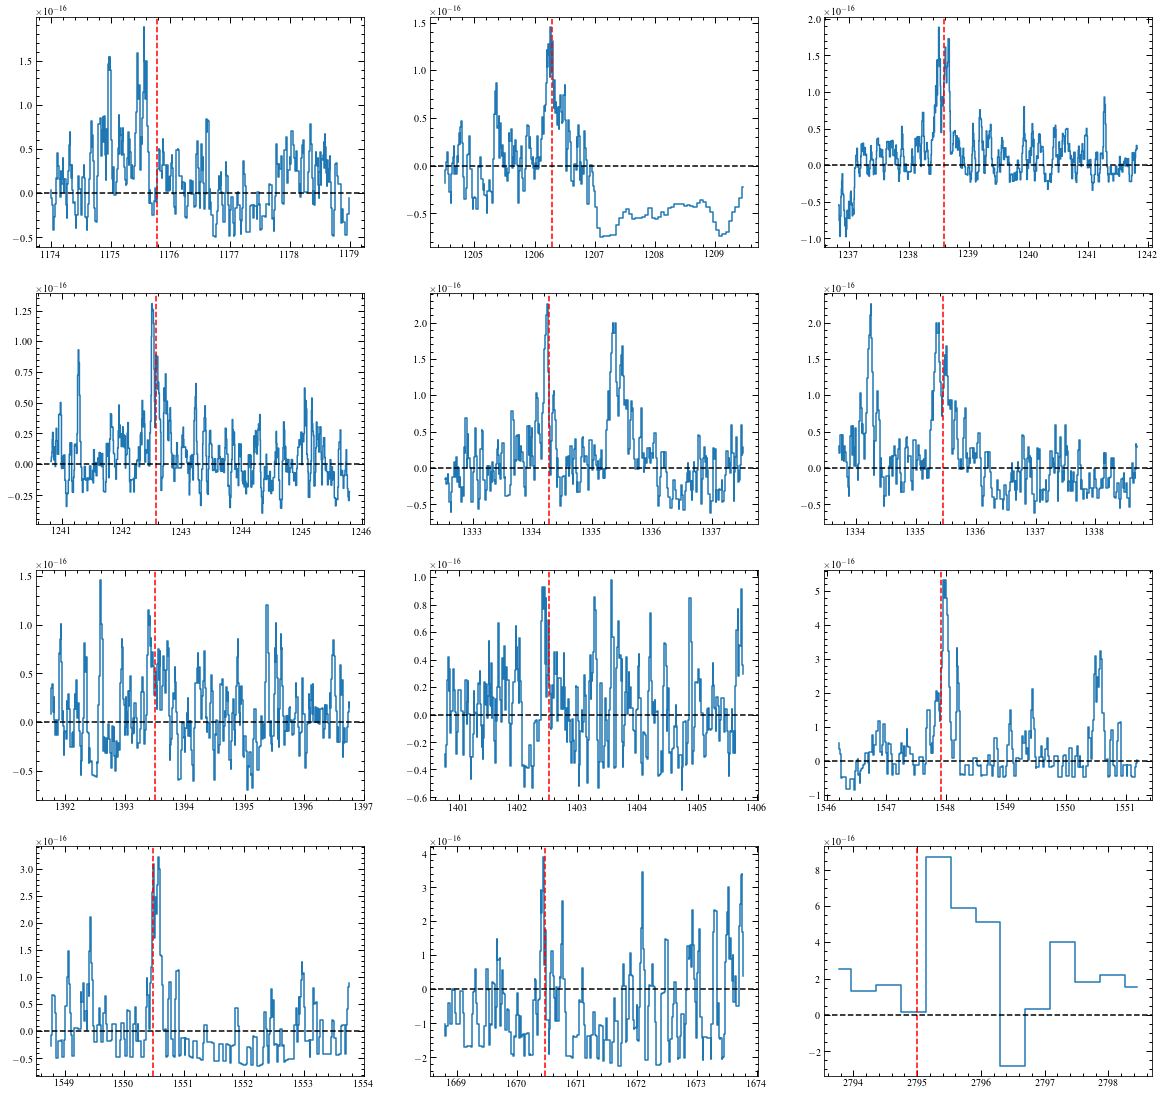

In [11]:
plt.figure(figsize=(20, 50))
for i, line in enumerate(detected_lines):
    line_mask = (w > line-2) & (w < line+3)
    w1, f1, e1 = w[line_mask], f[line_mask], e[line_mask]
    if line < 1750:
        f1 = convolve(f1,Box1DKernel(smooth))
        e1 = convolve(e1,Box1DKernel(smooth))/smooth**0.5
    #plt.figure(figsize=(5,5))
    plt.subplot(10, 3, i+1)
    plt.step(w1, f1, where='mid')
    dv_line = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA))
    plt.axvline(dv_line.value, c='r', ls='--')
    plt.axhline(0,c='k', ls='--')

In [12]:
fitter = fitting.LevMarLSQFitter()


4.2104334478457356e-17 5.294406144765981e-17 -1.8878304189775972e-17 1.2846620970905554e-16 4.2104334478457356e-17
4.383470630781589e-16 4.5182159686045015e-17 3.386300159835626e-16 3.690299984142773e-16 2.2309845129794566e-17
1175.4959999999999 8.16636498055298e-17 3.906010477724866e-16
1206.51 4.546333330529332e-17 8.144952189506584e-18
1238.821 5.290199570313293e-17 1.00821808649451e-17
1334.532 9.16666040696926e-17 3.336724668726945e-17
1393.755 2.1215676904874537e-17 1.8741771103628282e-17
1402.77 1.0586271804924283e-17 7.032604804362475e-18
1548.202 1.488500749672665e-16 9.957608552145026e-17
2795.523 6.280376099121266e-16 3.7566419106310353e-16


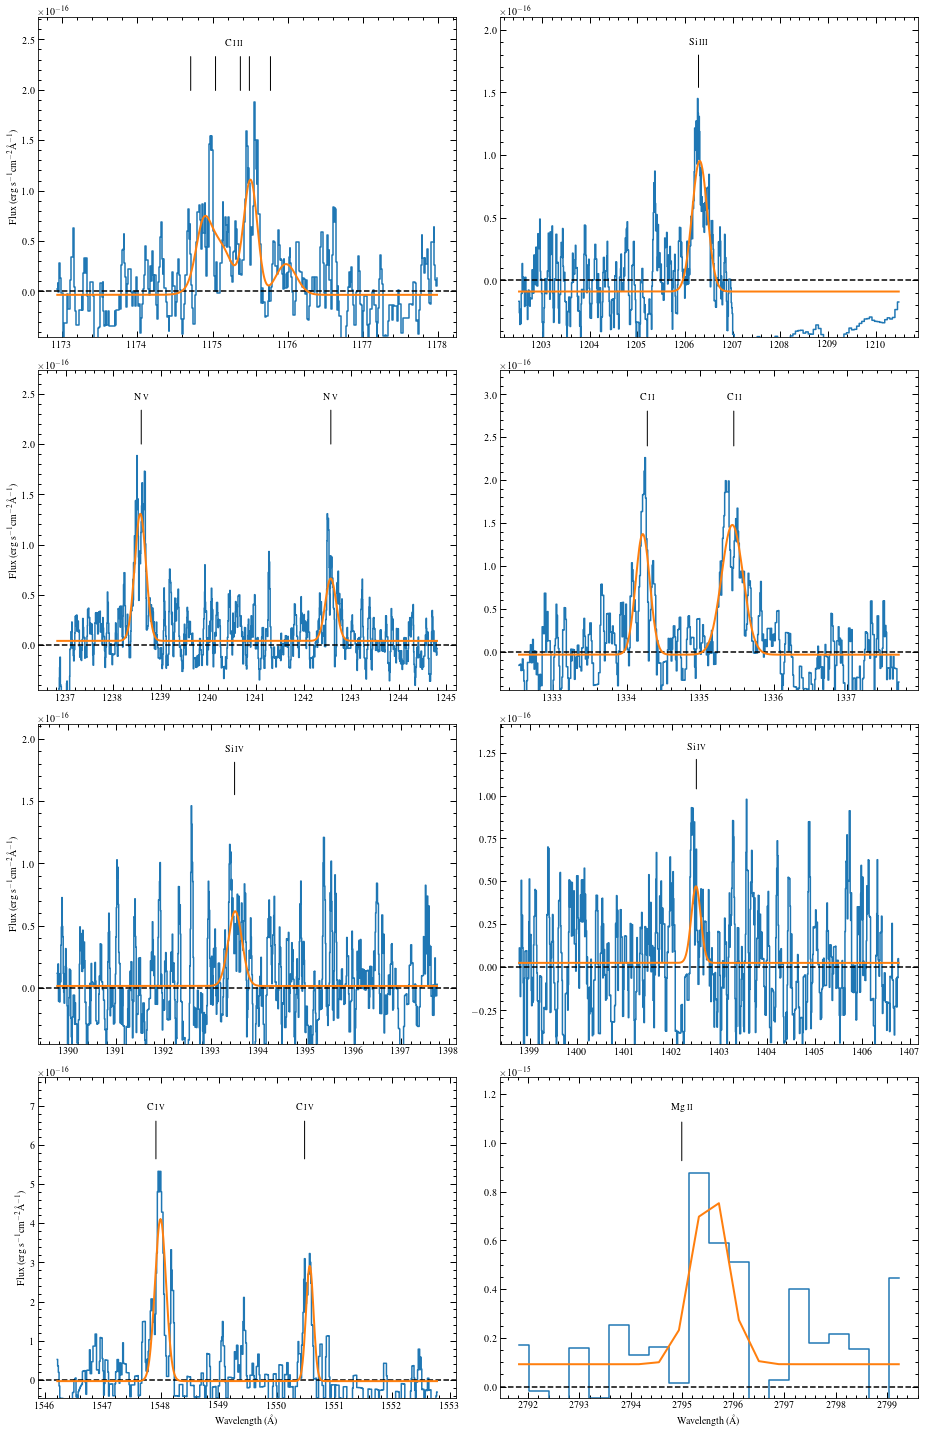

In [13]:
def gauss_flux(amp, std, off, ae, se, oe):
    """
    Calcualates the flux and error of a Gaussian with amplitude and stddev amp and std, with offset off
    """
    off_err = 0
    if off != 0.0:
        amp += (-1*off)
        off_err = (oe/off)**2
        
    flux = ((2*np.pi)**0.5) * amp * std
    error = flux * (((ae/amp)**2)+((se/std)**2)+off_err)**0.5
    return flux, error
               


ciii_1175 = [1174.93,1175.26,1175.59,1175.71,1175.99]
siiii_1206 = [1206.51, 1206.53]
nv_1240 = [1238.821, 1242.804]
ci_1288 = [1288.918]
feii_1292 = [1292.405]
cii_1335 = [1334.532, 1335.708]
feii_1527 = [1527.2397] 
civ_1550 = [1548.202,1550.774]
mgii_2800 = [2795.528]

line_fluxes = []
line_errors = [] 

measured_lines = [ciii_1175, [1206.51], nv_1240, cii_1335, [1393.755], [1402.77], civ_1550, [2795.523]]
plot_name = np.array(['C\,{\sc iii}', 'Si\,{\sc iii}', 'N\,{\sc v}', 'C\,{\sc ii}', 'Si\,{\sc iv}','Si\,{\sc iv}',
                       'C\,{\sc iv}', 'Mg\,{\sc ii}'])  


plt.figure(figsize=(13, 20))


for i, lineset in enumerate(measured_lines):
    line = lineset[0]
    if len(lineset) == 1:
        line_mask = (w > line-4) & (w < line+4)
    #elif i ==0:
     #   line_mask = (w > lineset[0]-4) & (w < lineset[-1]+4)
    else:
        line_mask = (w > lineset[0]-2) & (w < lineset[-1]+2)
    w1, f1, e1 = w[line_mask], f[line_mask], e[line_mask]
    if line < 1750:
        f1 = convolve(f1,Box1DKernel(smooth))
        e1 = convolve(e1,Box1DKernel(smooth))/smooth**0.5
    #plt.figure(figsize=(5,5))
    plt.subplot(4, 2, i+1)
    plt.step(w1, f1, where='mid')
    #dv_lines = [dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)) for line in lineset]
    #[plt.axvline(dv_line.value, c='r', ls='--') for dv_line in dv_lines]
    plt.axhline(0,c='k', ls='--') 
    gg_init = models.Const1D(0.0)
    for li in lineset:
        #if i in [5,7]:
         #   li -=0.2
        li = dv.to(u.AA, equivalencies=u.doppler_optical(li*u.AA))
        gg_init += models.Gaussian1D(1e-16, li,0.1)
    gg_fit = fitter(gg_init, w1, f1, maxiter=10000)
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    if i ==0:
        print(gg_fit[1].amplitude.value, gg_fit[2].amplitude.value, gg_fit[3].amplitude.value, gg_fit[4].amplitude.value, gg_fit[1].amplitude.value)
        print(fit_e[1], fit_e[4], fit_e[7], fit_e[10], fit_e[13])
    plt.plot(w1,gg_fit(w1), lw=2)
    #minplot = -abs(f1[int(len(f1)/2)])*1.1
    plt.ylim(-0.45e-16, max(f1)*1.45)
    dv_lines = [dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value for line in lineset]
    #[plt.annotate(name,(line*dshift, top*1.05), xytext=(line*dshift, top*1.3), horizontalalignment='center') for name, line in zip(plot_name[nmask], lines[nmask])]
    [plt.annotate('',(dv_line, max(f1)*1.05), xytext=(dv_line, max(f1)*1.25),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for dv_line in dv_lines]
    name = plot_name[i]
    if i == 0:
        line = np.mean(lineset)
        dv_line = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value
        plt.annotate(name,(dv_line, max(f1*1.05)), xytext=(dv_line, max(f1)*1.3), horizontalalignment='center')
    else:
        dv_lines = [dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value for line in lineset]
        [plt.annotate(name,(dv_line, max(f1*1.05)), xytext=(dv_line, max(f1)*1.3), horizontalalignment='center') for dv_line in dv_lines]
    if i  in (0, 2, 4, 6):
        plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
    if i in (6,7):
        plt.xlabel('Wavelength (\AA)')
    #calculate flux
    off, oe = gg_fit[0].amplitude, fit_e[0]
    if i == 7:
        off, oe = 0,0
        
    flux = []
    error = []
    for i in range(len(lineset)):
        
        amp, ae = gg_fit[i+1].amplitude, fit_e[3*i+1]
        std, se = gg_fit[i+1].stddev, fit_e[3*i+2]
        if amp > 0 and std >0: 
            f_l, e_l = gauss_flux(amp, std, off, ae, se, oe)
            flux.append(f_l)
            error.append(e_l)
    flux = np.sum(np.array(flux))
    error = np.sum(np.array(error)**2)**0.5
    line_fluxes.append(flux)
    line_errors.append(error)
    print(line, flux, error)
        
        

        
plt.tight_layout()
#plt.savefig('t1_detected_lines.pdf', dpi=150)
                   

    
    


In [14]:
table_lines = [ciii_1175, [1206.51], nv_1240, cii_1335, [1393.755], [1402.77], civ_1550, [2795.523]]

1174.93 8.16636498055298e-17 3.906010477724866e-16
1206.51 3.1945515281003576e-17 3.6124368586588016e-17
1238.821 3.0127842821419246e-17 8.092109796120885e-18
1242.804 1.255479775290944e-17 4.4506272390530845e-18
1334.532 2.707494402232861e-17 1.5210990141247254e-17
1335.708 4.1966616555529674e-17 1.4124139326260684e-17
1393.755 2.6317576537396074e-17 3.492951674977361e-17
1402.77 1.4546104244179898e-17 1.5273986872206495e-17
1548.202 8.776734373592022e-17 7.351203962758219e-17
1550.774 5.0914300349074414e-17 3.567634437054617e-17
2795.523 5.579850752519214e-16 4.073805929893201e-16


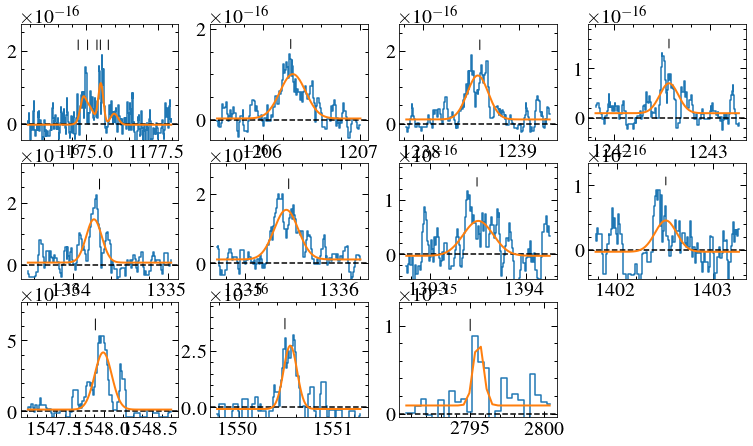

In [55]:
ciii_1175 = [1174.93,1175.26,1175.59,1175.71,1175.99]
siiii_1206 = [1206.51, 1206.53]
nv_1240 = [1238.821, 1242.804]
ci_1288 = [1288.918]
feii_1292 = [1292.405]
cii_1335 = [1334.532, 1335.708]
feii_1527 = [1527.2397] 
civ_1550 = [1548.202,1550.774]
mgii_2800 = [2795.528]

line_fluxes = []
line_errors = [] 
stds = []
amps = []
means = []
offs = []

measured_lines2 = [ciii_1175, [1206.51],[1238.821], [1242.804] ,[1334.532], [1335.708], [1393.755], [1402.77], [1548.202],[1550.774], [2795.523]]
#plot_name = np.array(['C\,{\sc iii}', 'Si\,{\sc iii}', 'N\,{\sc v}', 'C\,{\sc ii}', 'Si\,{\sc iv}','Si\,{\sc iv}',
                   #    'C\,{\sc iv}', 'Mg\,{\sc ii}'])  


plt.figure(figsize=(13, 20))


for i, lineset in enumerate(measured_lines2):
    line = lineset[0]
    if i ==10:
        line_mask = (w > lineset[0]-5) & (w < lineset[0]+5)
    elif len(lineset) == 1:
        line_mask = (w > line-1) & (w < line+0.5)
    else:
        line_mask = (w > lineset[0]-2) & (w < lineset[-1]+2)
    w1, f1, e1 = w[line_mask], f[line_mask], e[line_mask]
    if line < 1750:
        f1 = convolve(f1,Box1DKernel(smooth))
        e1 = convolve(e1,Box1DKernel(smooth))/smooth**0.5
    #plt.figure(figsize=(5,5))
    plt.subplot(8, 4, i+1)
    plt.step(w1, f1, where='mid')
    #dv_lines = [dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)) for line in lineset]
    #[plt.axvline(dv_line.value, c='r', ls='--') for dv_line in dv_lines]
    plt.axhline(0,c='k', ls='--') 
    gg_init = models.Const1D(0.0)
    for li in lineset:
        #if i in [5,7]:
         #   li -=0.2
        li = dv.to(u.AA, equivalencies=u.doppler_optical(li*u.AA))
        gg_init += models.Gaussian1D(1e-16, li,0.1)
    gg_fit = fitter(gg_init, w1, f1, maxiter=10000)
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
  #  if i ==0:
   #     print(gg_fit[1].amplitude.value, gg_fit[2].amplitude.value, gg_fit[3].amplitude.value, gg_fit[4].amplitude.value, gg_fit[1].amplitude.value)
    #    print(fit_e[1], fit_e[4], fit_e[7], fit_e[10], fit_e[13])
    plt.plot(w1,gg_fit(w1), lw=2)
    #minplot = -abs(f1[int(len(f1)/2)])*1.1
    plt.ylim(-0.45e-16, max(f1)*1.45)
    dv_lines = [dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value for line in lineset]
    #[plt.annotate(name,(line*dshift, top*1.05), xytext=(line*dshift, top*1.3), horizontalalignment='center') for name, line in zip(plot_name[nmask], lines[nmask])]
    [plt.annotate('',(dv_line, max(f1)*1.05), xytext=(dv_line, max(f1)*1.25),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for dv_line in dv_lines]
    #name = plot_name[i]
 #   if i == 0:
  #      line = np.mean(lineset)
   #     dv_line = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value
    #    plt.annotate(name,(dv_line, max(f1*1.05)), xytext=(dv_line, max(f1)*1.3), horizontalalignment='center')
  #  else:
   #     dv_lines = [dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value for line in lineset]
    #    [plt.annotate(name,(dv_line, max(f1*1.05)), xytext=(dv_line, max(f1)*1.3), horizontalalignment='center') for dv_line in dv_lines]
   # if i  in (0, 2, 4, 6):
   #     plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
   # if i in (6,7):
   #     plt.xlabel('Wavelength (\AA)')
    #calculate flux
    off, oe = gg_fit[0].amplitude, fit_e[0]
    #if i == 10:
     #   oe = 0.1*off
    
    flux = []
    error = []
    for j in range(len(lineset)):
        
        amp, ae = gg_fit[j+1].amplitude, fit_e[3*j+1]
        std, se = gg_fit[j+1].stddev, fit_e[3*j+2]
        if amp > 0: 
            f_l, e_l = gauss_flux(amp, std, off, ae, se, oe)
            flux.append(f_l)
            error.append(e_l)
    flux = np.sum(np.array(flux))
    error = np.sum(np.array(error)**2)**0.5
    line_fluxes.append(flux)
    line_errors.append(error)
    print(line, flux, error)
  
    if i > 0:
        stds.append(gg_fit[1].stddev.value)
        amps.append(gg_fit[1].amplitude.value)
        means.append(gg_fit[1].mean.value)
        offs.append(gg_fit[0].amplitude.value)
    
lines_table = Table([amps, means, stds, offs], names =['Amplitude', 'Mean', 'Stddev', 'Offset'])
ascii.write(lines_table, 'emmision_lines_for.model.ecsv', format='ecsv', overwrite=True)        

        
#plt.tight_layout()

In [16]:
def Round_n_sig_dig(x, n):

    import numpy as np               
    xr = (np.floor(np.log10(np.abs(x)))).astype(int)
    xr=10.**xr*np.around(x/10.**xr,n-1)   
    return xr

table_lines = [1176, 1206.51,1238.821, 1242.804 ,1334.532, 1335.708, 1393.755, 1402.77, 1548.202,1550.774, 2795.523]
table_fluxes, table_errors = np.array(line_fluxes)*1e18,np.array(line_errors)*1e18
table_fluxes, table_errors = Round_n_sig_dig(table_fluxes,2), Round_n_sig_dig(table_errors, 2)

for tl, tf, te in zip(table_lines, table_fluxes, table_errors):
    print(tl,tf,te)

1176 82.0 390.0
1206.51 32.0 36.0
1238.821 30.0 8.1
1242.804 13.0 4.5
1334.532 27.0 15.0
1335.708 42.0 14.0
1393.755 26.0 35.0
1402.77 15.0 15.0
1548.202 88.0 74.0
1550.774 51.0 36.0
2795.523 560.0 409.99999999999994


Need to measure the C line differently

In [17]:
fluxtable=dict(Line=np.array(table_lines), Flux=np.array(line_fluxes), Error=np.array(line_errors))
fluxtable

{'Line': array([1176.   , 1206.51 , 1238.821, 1242.804, 1334.532, 1335.708,
        1393.755, 1402.77 , 1548.202, 1550.774, 2795.523]),
 'Flux': array([8.16636498e-17, 3.19455153e-17, 3.01278428e-17, 1.25547978e-17,
        2.70749440e-17, 4.19666166e-17, 2.63175765e-17, 1.45461042e-17,
        8.77673437e-17, 5.09143003e-17, 5.57985075e-16]),
 'Error': array([3.90601048e-16, 3.61243686e-17, 8.09210980e-18, 4.45062724e-18,
        1.52109901e-17, 1.41241393e-17, 3.49295167e-17, 1.52739869e-17,
        7.35120396e-17, 3.56763444e-17, 4.07380593e-16])}

In [18]:
ascii.write(fluxtable, format='latex')  

\begin{table}
\begin{tabular}{ccc}
Line & Flux & Error \\
1176.0 & 8.16636498055298e-17 & 3.906010477724866e-16 \\
1206.51 & 3.1945515281003576e-17 & 3.6124368586588016e-17 \\
1238.821 & 3.0127842821419246e-17 & 8.092109796120885e-18 \\
1242.804 & 1.255479775290944e-17 & 4.4506272390530845e-18 \\
1334.532 & 2.707494402232861e-17 & 1.5210990141247254e-17 \\
1335.708 & 4.1966616555529674e-17 & 1.4124139326260684e-17 \\
1393.755 & 2.6317576537396074e-17 & 3.492951674977361e-17 \\
1402.77 & 1.4546104244179898e-17 & 1.5273986872206495e-17 \\
1548.202 & 8.776734373592022e-17 & 7.351203962758219e-17 \\
1550.774 & 5.0914300349074414e-17 & 3.567634437054617e-17 \\
2795.523 & 5.579850752519214e-16 & 4.073805929893201e-16 \\
\end{tabular}
\end{table}


Upper limits

In [19]:
non_detect = []
for line in line_data:
    if line not in table_lines:
        non_detect.append(line)
non_detect = np.array(non_detect)
non_detect

array([1218.344, 1351.657, 1355.598, 1371.292, 1401.156, 1548.195,
       1550.77 , 1561.   , 1643.   , 1666.153, 1670.787, 2802.697])

In [20]:
stds

[0.1331359779711997,
 0.10950208163923028,
 0.09707803507870395,
 0.08113914972560146,
 0.1259528655306035,
 0.1563785338861881,
 0.11180052032527811,
 0.088918194108146,
 0.07026369866845261,
 0.3345141668218898]

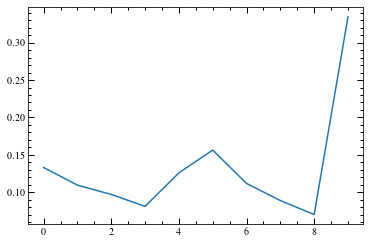

In [21]:
plt.plot(range(len(stds)), stds)

In [22]:
#fwhm = 2.355 *sigma
std1 = np.mean(stds[:-1])
std2 = stds[-1]
std1, std2

(0.10824100632593375, 0.3345141668218898)

In [23]:
nd_flux = []

for i, line in enumerate(non_detect):
    line = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value
    rng = std1
    if line > 1750:
        rng = std2
    cut = 3*rng
    line_mask = (w > line - cut ) & (w < line+ cut)

    w1, f1, e1 = w[line_mask], f[line_mask], e[line_mask]
    if line < 1750:
        f1 = convolve(f1,Box1DKernel(smooth))
        e1 = convolve(e1,Box1DKernel(smooth))/smooth**0.5
   # plt.step(w1, f1, where='mid')
   # plt.step(w1, e1, where='mid')
   # plt.axvline(line, c ='r', ls='--')
    rms = np.sqrt(np.mean(f1**2))
    nd_flux.append(rms)
    #plt.show()
print(nd_flux)

[2.898367361625743e-17, 2.6468391247811415e-17, 3.5090918092287924e-17, 3.186065340442371e-17, 2.0848598451713904e-17, 2.3843963504000003e-16, 1.3168759373435621e-16, 3.329656878390709e-17, 8.659622029336134e-17, 1.1873857773394032e-16, 1.4024405523435785e-16, 2.3799950603147736e-16]


In [24]:
nd_e = np.zeros(len(nd_flux))

In [25]:
pl = np.concatenate((table_lines, non_detect))
pf = np.concatenate((line_fluxes, nd_flux))
pe = np.concatenate((line_errors, nd_e))
for wl, fl, el in zip(pl, pf, pe):
    print(wl, fl, el)

1176.0 8.16636498055298e-17 3.906010477724866e-16
1206.51 3.1945515281003576e-17 3.6124368586588016e-17
1238.821 3.0127842821419246e-17 8.092109796120885e-18
1242.804 1.255479775290944e-17 4.4506272390530845e-18
1334.532 2.707494402232861e-17 1.5210990141247254e-17
1335.708 4.1966616555529674e-17 1.4124139326260684e-17
1393.755 2.6317576537396074e-17 3.492951674977361e-17
1402.77 1.4546104244179898e-17 1.5273986872206495e-17
1548.202 8.776734373592022e-17 7.351203962758219e-17
1550.774 5.0914300349074414e-17 3.567634437054617e-17
2795.523 5.579850752519214e-16 4.073805929893201e-16
1218.344 2.898367361625743e-17 0.0
1351.657 2.6468391247811415e-17 0.0
1355.598 3.5090918092287924e-17 0.0
1371.292 3.186065340442371e-17 0.0
1401.156 2.0848598451713904e-17 0.0
1548.195 2.3843963504000003e-16 0.0
1550.77 1.3168759373435621e-16 0.0
1561.0 3.329656878390709e-17 0.0
1643.0 8.659622029336134e-17 0.0
1666.153 1.1873857773394032e-16 0.0
1670.787 1.4024405523435785e-16 0.0
2802.697 2.3799950603147

In [26]:
for i  in range(len(pl)):
    if pe[i] > pf[i]:
        #pf[i] = pe[i]
        pe[i] = -1

pargs = np.argsort(pl)
pl, pf, pe = pl[pargs], pf[pargs], pe[pargs]

pf *= 1e18
pe *= 1e18
pf, pe = Round_n_sig_dig(pf,2), Round_n_sig_dig(pe, 2)


for wl, fl, el in zip(pl, pf, pe):
    print(wl, fl, el)

1176.0 82.0 -1e+18
1206.51 32.0 -1e+18
1218.344 29.0 nan
1238.821 30.0 8.1
1242.804 13.0 4.5
1334.532 27.0 15.0
1335.708 42.0 14.0
1351.657 26.0 nan
1355.598 35.0 nan
1371.292 32.0 nan
1393.755 26.0 -1e+18
1401.156 21.0 nan
1402.77 15.0 -1e+18
1548.195 240.0 nan
1548.202 88.0 74.0
1550.77 130.0 nan
1550.774 51.0 36.0
1561.0 33.0 nan
1643.0 87.0 nan
1666.153 120.0 nan
1670.787 140.0 nan
2795.523 560.0 409.99999999999994
2802.697 240.0 nan


/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [27]:
for wv, name in zip(line_tab['Wavelength'], line_tab['Ion']):
    if wv*10 >1100: 
        print(wv*10, name)

1176.0 Ciii
1206.51 Siiii
1215.6699999999998 Hi (Lyα)
1218.344 Ov
1238.821 Nv
1242.804 Nv
1302.169 Oi
1304.8580000000002 Oi
1306.029 Oi
1334.5320000000002 Cii
1335.7079999999999 Cii
1351.657 Cli
1355.598 Oi
1371.292 Ov
1393.7549999999999 Siiv
1401.156 Oiv
1402.77 Siiv
1548.1950000000002 Civ
1550.77 Civ
1561.0 Ci
1643.0 Heii
1666.1529999999998 Oiii
1670.787 Alii
1892.03 Siiii
1908.7 Ciii
2325.0 Cii
2340.0 Siii
2795.523 Mgiik
2802.697 Mgiih


In [28]:
pn = ['Ciii', 'Siiii', 'Ov', 'Nv', 'Nv', 'Cii', 'Cii', 'Cli', 'Oi', 'Ov','Ci','Ci', 'Siiv', 'Oi','Siiv','Civ', 'Civ', 'Ci', 'Heii', 'Oiii', 'Alii', 'Mgiik', 'Mgiih']
len(pn), len(pl)

(23, 23)

In [29]:
for nl, wl, fl, el in zip(pn, pl, pf, pe):
    print(nl, wl, fl, el)

Ciii 1176.0 82.0 -1e+18
Siiii 1206.51 32.0 -1e+18
Ov 1218.344 29.0 nan
Nv 1238.821 30.0 8.1
Nv 1242.804 13.0 4.5
Cii 1334.532 27.0 15.0
Cii 1335.708 42.0 14.0
Cli 1351.657 26.0 nan
Oi 1355.598 35.0 nan
Ov 1371.292 32.0 nan
Ci 1393.755 26.0 -1e+18
Ci 1401.156 21.0 nan
Siiv 1402.77 15.0 -1e+18
Oi 1548.195 240.0 nan
Siiv 1548.202 88.0 74.0
Civ 1550.77 130.0 nan
Civ 1550.774 51.0 36.0
Ci 1561.0 33.0 nan
Heii 1643.0 87.0 nan
Oiii 1666.153 120.0 nan
Alii 1670.787 140.0 nan
Mgiik 2795.523 560.0 409.99999999999994
Mgiih 2802.697 240.0 nan


Calculate Ciii 1176 line using width of combined line.

4.2104334478457356e-17 5.294406144765981e-17 -1.8878304189775972e-17 1.2846620970905554e-16 4.2104334478457356e-17
4.383470630781589e-16 4.5182159686045015e-17 3.386300159835626e-16 3.690299984142773e-16 2.2309845129794566e-17
flux 6.987076217063271e-17
errror 5.439931240629968e-17


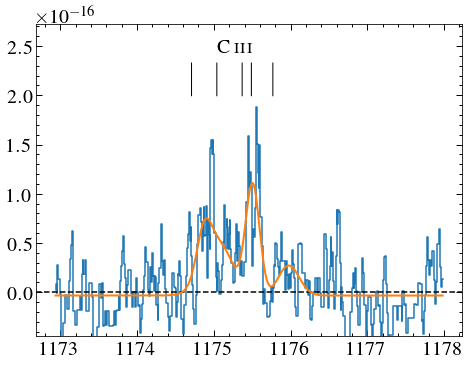

In [59]:
def gauss_flux(amp, std, off, ae, se, oe):
    """
    Calcualates the flux and error of a Gaussian with amplitude and stddev amp and std, with offset off
    """
    off_err = 0
    if off != 0.0:
        amp += (-1*off)
        off_err = (oe/off)**2
        
    flux = ((2*np.pi)**0.5) * amp * std
    error = flux * (((ae/amp)**2)+((se/std)**2)+off_err)**0.5
    return flux, error
               


ciii_1175 = [1174.93,1175.26,1175.59,1175.71,1175.99]
siiii_1206 = [1206.51, 1206.53]
nv_1240 = [1238.821, 1242.804]
ci_1288 = [1288.918]
feii_1292 = [1292.405]
cii_1335 = [1334.532, 1335.708]
feii_1527 = [1527.2397] 
civ_1550 = [1548.202,1550.774]
mgii_2800 = [2795.528]

line_fluxes = []
line_errors = [] 

measured_lines = [ciii_1175, [1206.51], nv_1240, cii_1335, [1393.755], [1402.77], civ_1550, [2795.523]]
plot_name = np.array(['C\,{\sc iii}', 'Si\,{\sc iii}', 'N\,{\sc v}', 'C\,{\sc ii}', 'Si\,{\sc iv}','Si\,{\sc iv}',
                       'C\,{\sc iv}', 'Mg\,{\sc ii}'])  


plt.figure(figsize=(13, 20))


#for i, lineset in enumerate(measured_lines[0]):
i = 0
lineset = ciii_1175
line = lineset[0]
if len(lineset) == 1:
    line_mask = (w > line-4) & (w < line+4)
#elif i ==0:
 #   line_mask = (w > lineset[0]-4) & (w < lineset[-1]+4)
else:
    line_mask = (w > lineset[0]-2) & (w < lineset[-1]+2)
w1, f1, e1 = w[line_mask], f[line_mask], e[line_mask]
if line < 1750:
    f1 = convolve(f1,Box1DKernel(smooth))
    e1 = convolve(e1,Box1DKernel(smooth))/smooth**0.5
#plt.figure(figsize=(5,5))
plt.subplot(4, 2, i+1)
plt.step(w1, f1, where='mid')
#dv_lines = [dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)) for line in lineset]
#[plt.axvline(dv_line.value, c='r', ls='--') for dv_line in dv_lines]
plt.axhline(0,c='k', ls='--') 
gg_init = models.Const1D(0.0)
for li in lineset:
    #if i in [5,7]:
     #   li -=0.2
    li = dv.to(u.AA, equivalencies=u.doppler_optical(li*u.AA))
    gg_init += models.Gaussian1D(1e-16, li,0.1)
gg_fit = fitter(gg_init, w1, f1, maxiter=10000)
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
if i ==0:
    print(gg_fit[1].amplitude.value, gg_fit[2].amplitude.value, gg_fit[3].amplitude.value, gg_fit[4].amplitude.value, gg_fit[1].amplitude.value)
    print(fit_e[1], fit_e[4], fit_e[7], fit_e[10], fit_e[13])
plt.plot(w1,gg_fit(w1), lw=2)
#minplot = -abs(f1[int(len(f1)/2)])*1.1
plt.ylim(-0.45e-16, max(f1)*1.45)
dv_lines = [dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value for line in lineset]
#[plt.annotate(name,(line*dshift, top*1.05), xytext=(line*dshift, top*1.3), horizontalalignment='center') for name, line in zip(plot_name[nmask], lines[nmask])]
[plt.annotate('',(dv_line, max(f1)*1.05), xytext=(dv_line, max(f1)*1.25),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for dv_line in dv_lines]
name = plot_name[i]
if i == 0:
    line = np.mean(lineset)
    dv_line = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value
    plt.annotate(name,(dv_line, max(f1*1.05)), xytext=(dv_line, max(f1)*1.3), horizontalalignment='center')
else:
    dv_lines = [dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value for line in lineset]
    [plt.annotate(name,(dv_line, max(f1*1.05)), xytext=(dv_line, max(f1)*1.3), horizontalalignment='center') for dv_line in dv_lines]

edges = [1174.5, 1176.5]
fmask = (w1 > edges[0]) & (w1 < edges[1])
#mflux = np.trapz(gg_fit(w1[fmask]), w1[fmask])
mflux = np.trapz(f1[fmask], w1[fmask]) + abs(gg_fit[0].amplitude)
e_range = [[1173, 1174], [1177, 1178]]
er = 0
for rg in e_range:
    emask = (w1 > rg[0]) & (w1 < rg[1])
    er += np.sqrt(np.mean(f1[emask]**2))

print('flux', mflux)
print('errror', er)


        
plt.tight_layout()
#plt.savefig('t1_detected_lines.pdf', dpi=150)
                   
amps1 = [gg_fit[i+1].amplitude.value for i in range(len(lineset))]
means1 = [gg_fit[i+1].mean.value for i in range(len(lineset))]
stds1 = [gg_fit[i+1].stddev.value for i in range(len(lineset))]
offs1 = np.full(len(lineset), gg_fit[0].amplitude)

lines_table1 = Table([amps1, means1, stds1, offs1], names =['Amplitude', 'Mean', 'Stddev', 'Offset'])
ascii.write(lines_table1, 'ciii1176_lines_for.model.ecsv', format='ecsv', overwrite=True)     
    
    


In [40]:
pf[0] = Round_n_sig_dig(mflux*1e18,2)
pe[0] = Round_n_sig_dig(er*1e18,2)
for nl, wl, fl, el in zip(pn, pl, pf, pe):
    print(nl, wl, fl, el)

Ciii 1176.0 70.0 54.0
Siiii 1206.51 32.0 -1e+18
Ov 1218.344 29.0 nan
Nv 1238.821 30.0 8.1
Nv 1242.804 13.0 4.5
Cii 1334.532 27.0 15.0
Cii 1335.708 42.0 14.0
Cli 1351.657 26.0 nan
Oi 1355.598 35.0 nan
Ov 1371.292 32.0 nan
Ci 1393.755 26.0 -1e+18
Ci 1401.156 21.0 nan
Siiv 1402.77 15.0 -1e+18
Oi 1548.195 240.0 nan
Siiv 1548.202 88.0 74.0
Civ 1550.77 130.0 nan
Civ 1550.774 51.0 36.0
Ci 1561.0 33.0 nan
Heii 1643.0 87.0 nan
Oiii 1666.153 120.0 nan
Alii 1670.787 140.0 nan
Mgiik 2795.523 560.0 409.99999999999994
Mgiih 2802.697 240.0 nan


In [41]:
for i in range(len(pe)):
    if np.isnan(pe[i]) == True:
        pe[i]  = -1e-18

In [47]:
for nl, wl, fl, el in zip(pn, pl, pf, pe):
    if el > 0.0:
        print('{} & {} & ${}\pm{}$ \\\\'.format(nl, wl, fl, el))
    else:
        print('{} & {} & $\leq{}$ \\\\'.format(nl, wl, fl))

Ciii & 1176.0 & $70.0\pm54.0$ \\
Siiii & 1206.51 & $\leq32.0$ \\
Ov & 1218.344 & $\leq29.0$ \\
Nv & 1238.821 & $30.0\pm8.1$ \\
Nv & 1242.804 & $13.0\pm4.5$ \\
Cii & 1334.532 & $27.0\pm15.0$ \\
Cii & 1335.708 & $42.0\pm14.0$ \\
Cli & 1351.657 & $\leq26.0$ \\
Oi & 1355.598 & $\leq35.0$ \\
Ov & 1371.292 & $\leq32.0$ \\
Ci & 1393.755 & $\leq26.0$ \\
Ci & 1401.156 & $\leq21.0$ \\
Siiv & 1402.77 & $\leq15.0$ \\
Oi & 1548.195 & $\leq240.0$ \\
Siiv & 1548.202 & $88.0\pm74.0$ \\
Civ & 1550.77 & $\leq130.0$ \\
Civ & 1550.774 & $51.0\pm36.0$ \\
Ci & 1561.0 & $\leq33.0$ \\
Heii & 1643.0 & $\leq87.0$ \\
Oiii & 1666.153 & $\leq120.0$ \\
Alii & 1670.787 & $\leq140.0$ \\
Mgiik & 2795.523 & $560.0\pm409.99999999999994$ \\
Mgiih & 2802.697 & $\leq240.0$ \\


In [60]:
lines_table1

Amplitude,Mean,Stddev,Offset
float64,float64,float64,float64
4.2104334478457356e-17,1174.8719440535478,0.09417872214871711,-3.405353793032737e-18
5.294406144765981e-17,1175.0616874598966,0.1989112822062342,-3.405353793032737e-18
-1.8878304189775972e-17,1175.481251299445,0.1421652727877183,-3.405353793032737e-18
1.2846620970905554e-16,1175.504637081705,0.09417430632188963,-3.405353793032737e-18
3.0539084984471406e-17,1175.9746279076462,0.13744787385110166,-3.405353793032737e-18


Adding the lines from P+19 not in the L+17 linelist 

In [61]:
mlines = np.genfromtxt('phoenix_model_lines.txt', delimiter='\t', names=True, dtype=None,encoding=None)

In [62]:
mlines

array([('Si II', 1264.73, 1.108300e+02, 1.20000e-01, 2.44500e+01, False),
       ('Si III', 1298.95, 2.900000e-01, 5.00000e-02, 1.00000e-01, False),
       ('O I', 1302.17, 5.010000e+00, 3.00000e-02, 7.30000e-01, False),
       ('O I', 1304.86, 4.520000e+00, 2.00000e-02, 4.80000e-01, False),
       ('O I', 1306.03, 3.540000e+00, 1.00000e-02, 2.40000e-01, False),
       ('Si II', 1309.28, 1.030900e+02, 7.91000e+00, 2.60800e+01, False),
       ('C II', 1335.71, 3.660000e+01, 1.80000e-01, 5.42000e+00, False),
       ('Fe II', 1391.08, 2.107200e+02, 3.68700e+01, 7.59400e+01, False),
       ('Si II', 1526.71, 4.429000e+01, 9.00000e-02, 5.92000e+00, False),
       ('Si II', 1533.43, 4.767000e+01, 2.00000e-01, 6.94000e+00, False),
       ('C IV', 1550.77, 1.712000e+01, 8.34000e+00, 9.83000e+00, False),
       ('Al II', 1670.79, 3.101400e+02, 1.10000e-01, 1.01200e+02, False),
       ('Al I', 1766.39, 4.709300e+02, 1.51800e+02, 1.58000e+02, False),
       ('Mg II k', 2796.35, 6.919410e+03, 1.28

In [63]:
#\ion{C}{iii} & 1176.0 & $70.0\pm54.0$ \\
#\ion{Si}{iii} & 1206.51 & $\leq32.0$ \\
#\ion{O}{v} & 1218.344 & $\leq29.0$ \\
#\ion{N}{v} & 1238.821 & $30.0\pm8.1$ \\
#\ion{N}{v} & 1242.804 & $13.0\pm4.5$ \\
#\ion{C}{ii} & 1334.532 & $27.0\pm15.0$ \\
#\ion{C}{ii} & 1335.708 & $42.0\pm14.0$ \\
#\ion{Cl}{i} & 1351.657 & $\leq26.0$ \\
#\ion{O}{i} & 1355.598 & $\leq35.0$ \\
#\ion{O}{v} & 1371.292 & $\leq32.0$ \\
#\ion{Si}{iv} & 1393.755 & $\leq26.0$ \\
#\ion{C}{i} & 1401.156 & $\leq21.0$ \\
#\ion{Si}{iv} & 1402.77 & $\leq15.0$ \\
#\ion{O}{i} & 1548.195 & $\leq240.0$ \\
#\ion{C}{iv} & 1548.202 & $88.0\pm74.0$ \\
#\ion{C}{iv} & 1550.774 & $51.0\pm36.0$ \\
#\ion{C}{i} & 1561.0 & $\leq33.0$ \\
#\ion{He}{ii} & 1643.0 & $\leq87.0$ \\
#\ion{O}{iii} & 1666.153 & $\leq120.0$ \\
#\ion{Al}{ii} & 1670.787 & $\leq140.0$ \\
#\ion{Mg}{ii}\,k & 2795.523 & $560.0\pm410$ \\
#\ion{Mg}{ii}\,h & 2802.697 & $\leq240.0$ \\

In [96]:
#lines not in list
pnames = ['Si ii','Si iii','Si ii','Fe II', 'Si ii',  'Si ii','Al i']
plines = [1264.73, 1298.95,1309.28, 1391.08, 1526.71,  1533.43, 1766.39]


Si ii 1264.73 18.0
Si iii 1298.95 5.3 2.2
Si ii 1309.28 5.8 2.6
Fe II 1391.08 36.0
Si ii 1526.71 39.0
Si ii 1533.43 35.0
Al i 1766.39 350.0


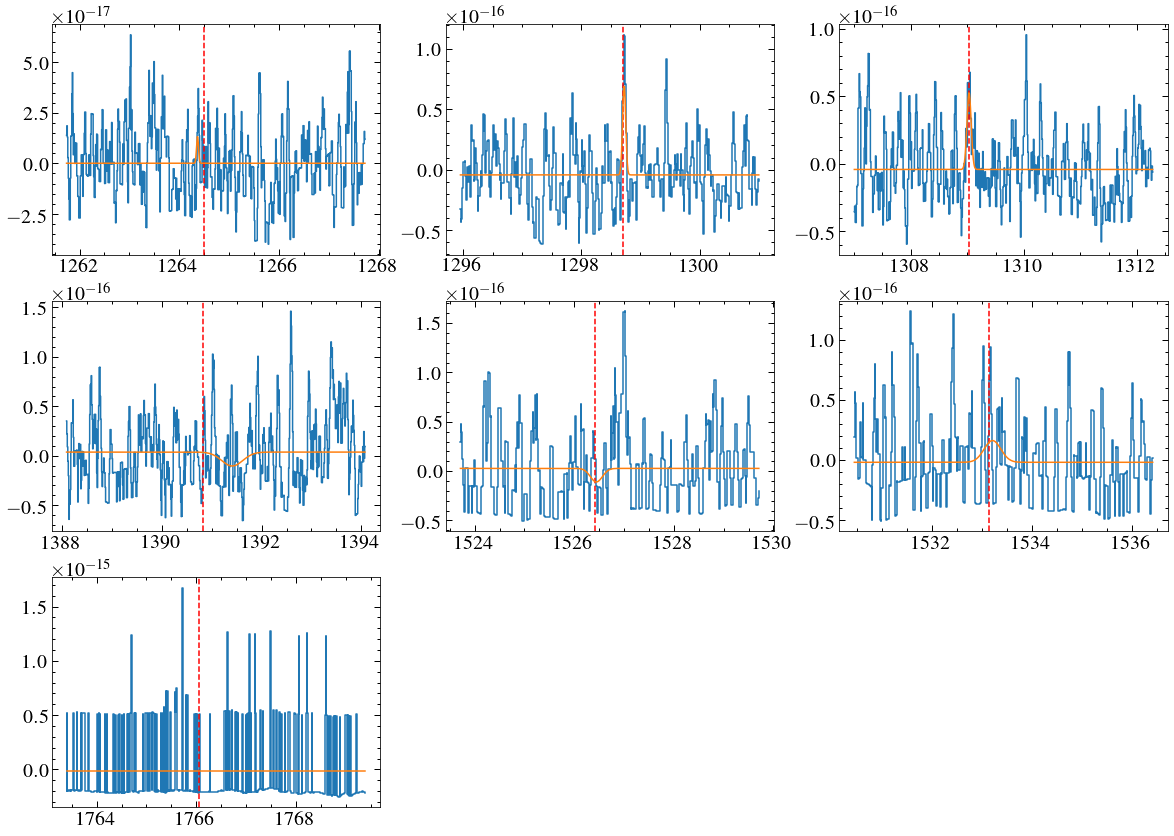

In [97]:
smooth = 5
dv = -56.3*u.km/u.s
plt.figure(figsize=(20, 50))
for i, line in enumerate(plines):
    line_mask = (w > line-3) & (w < line+3)
    w1, f1, e1 = w[line_mask], f[line_mask], e[line_mask]
    if line < 1750:
        f1 = convolve(f1,Box1DKernel(smooth))
        e1 = convolve(e1,Box1DKernel(smooth))/smooth**0.5
    #plt.figure(figsize=(5,5))
    plt.subplot(10, 3, i+1)
    plt.step(w1, f1, where='mid')
    dv_line = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA))
    plt.axvline(dv_line.value, c='r', ls='--')
    
    gg_init = models.Const1D(0.0)+models.Gaussian1D(1e-16, dv_line.value,0.1)
    gg_fit = fitter(gg_init, w1, f1, maxiter=10000)
    plt.plot(w1, gg_fit(w1))
    
    if i in (1,2):
        fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
        amp, ae = gg_fit[j+1].amplitude, fit_e[1]
        std, se = gg_fit[j+1].stddev, fit_e[3]
        off, oe = gg_fit[0].amplitude, fit_e[0]
        if amp > 0: 
            f_l, e_l = gauss_flux(amp, std, off, ae, se, oe)
        flux, error = Round_n_sig_dig(f_l*1e18,2), Round_n_sig_dig(e_l*1e18,2)
        print(pnames[i],line, flux, error)
    else:
        rng = std1
        if line > 1750:
            rng = std2
        cut = 3*rng
        line_mask = (w1 > line - cut ) & (w1 < line+ cut)
        w2, f2, e2 = w1[line_mask], f1[line_mask], e1[line_mask]
        rms = np.sqrt(np.mean(f1**2))
        flux = Round_n_sig_dig(rms*1e18,2)
        print(pnames[i], line, flux)
        
        #    flux.append(f_l)
         #   error.append(e_l)
    #flux = np.sum(np.array(flux))
    #error = np.sum(np.array(error)**2)**0.5
    #line_fluxes.append(flux)
    #line_errors.append(error)
    #print(line, flux, error)
    
    #plt.show()
    
    
   # for i, line in enumerate(non_detect):
    #line = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value
   
  #  nd_flux.append(rms)

In [89]:
std1

0.10824100632593375

In [109]:
pmes = np.array([18, 5.3, 5.8,(42+27),36, 39,35,(88+51),140,350,560, 240])
perr = np.array([0, 2.2, 2.6, (14**2+15**2)**0.5, 0,0,0,(74**2+36**2)**0.5, 0, 0,410, 0])
pmask = [True, True, False, False,False, True,True,True,True,True, True,True,True,True,True, False, False]
ptab = mlines[pmask]

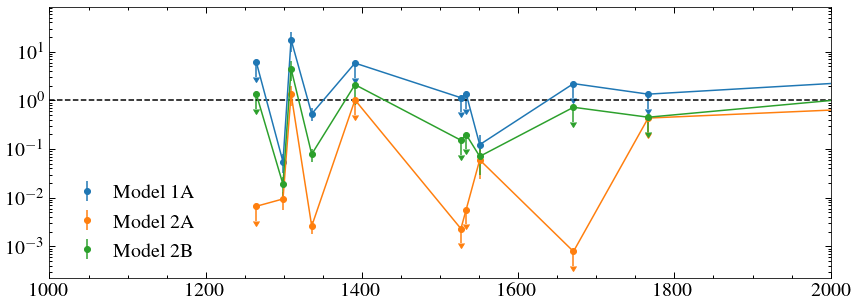

In [133]:

def plot_ratio(pmes, perr, model, colour):
    upmask = (perr > 0)
    ratio = ptab[model]/pmes
    error = ratio * (perr/pmes)
    plt.errorbar(ptab['lambda_angst'], ratio , yerr=0, c=colour)
    plt.errorbar(ptab['lambda_angst'][upmask], ratio[upmask], yerr=error[upmask], ls='none', marker='o', c=colour, label=model.replace('_',' '))
    plt.errorbar(ptab['lambda_angst'][~upmask], ratio[~upmask], yerr=ratio[~upmask]*0.5, ls='none', marker='o', uplims=True,c=colour)
    

plot_ratio(pmes, perr, 'Model_1A','C0')
plot_ratio(pmes, perr, 'Model_2A','C1')
plot_ratio(pmes, perr, 'Model_2B','C2')
#plt.errorbar(ptab['lambda_angst'][upmask], pmes[upmask], yerr=perr[upmask], ls='none', marker='o')
#plt.errorbar(ptab['lambda_angst'][~upmask], pmes[~upmask], yerr=5, ls='none', marker='o', uplims=True)
#plt.errorbar(ptab['lambda_angst'], ptab['Model_1A'], yerr=0,  marker='o')
#plt.errorbar(ptab['lambda_angst'], ptab['Model_2A'], yerr=0,  marker='o')
#plt.errorbar(ptab['lambda_angst'], ptab['Model_2B'], yerr=0,  marker='o')
plt.axhline(1, ls='--', c='k')
plt.xlim(1000, 2000)
#plt.xscale('log')
plt.yscale('log')
plt.legend()

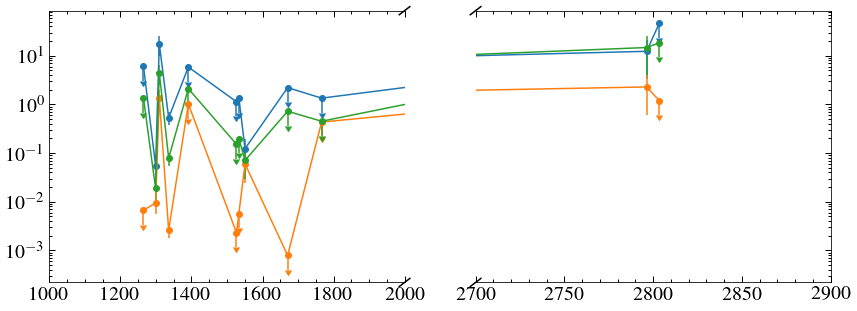

In [163]:
f, (ax, ax2) = plt.subplots(1, 2, sharey=True)

ax.set_yscale('log')

def plot_ratio(pmes, perr, model, colour):
    upmask = (perr > 0)
    ratio = ptab[model]/pmes
    error = ratio * (perr/pmes)
    ax.errorbar(ptab['lambda_angst'], ratio , yerr=0, c=colour)
    ax.errorbar(ptab['lambda_angst'][upmask], ratio[upmask], yerr=error[upmask], ls='none', marker='o', c=colour, label=model.replace('_',' '))
    ax.errorbar(ptab['lambda_angst'][~upmask], ratio[~upmask], yerr=ratio[~upmask]*0.5, ls='none', marker='o', uplims=True,c=colour)
    ax2.errorbar(ptab['lambda_angst'], ratio , yerr=0, c=colour)
    ax2.errorbar(ptab['lambda_angst'][upmask], ratio[upmask], yerr=error[upmask], ls='none', marker='o', c=colour, label=model.replace('_',' '))
    ax2.errorbar(ptab['lambda_angst'][~upmask], ratio[~upmask], yerr=ratio[~upmask]*0.5, ls='none', marker='o', uplims=True,c=colour)

plot_ratio(pmes, perr, 'Model_1A','C0')
plot_ratio(pmes, perr, 'Model_2A','C1')
plot_ratio(pmes, perr, 'Model_2B','C2')

ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.yaxis.tick_right()
#ax.tick_params(labelright='off')  # don't put tick labels at the top
ax.yaxis.tick_left()
ax.set_xlim(1000, 2000)
ax2.set_xlim(2700, 2900)
 
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1 - d, 1 + d), (1-d, 1+d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot(( - d,  + d), ( - d,  + d), **kwargs)  # bottom-right diagonal    